In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor as DaskRF# Parallel version
from statsmodels.api import OLS, add_constant
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from category_encoders import TargetEncoder
import warnings

In [53]:
# Load dataset
try:
    df = pd.read_csv("California_Fire_Incidents.csv")
    print(" Dataset loaded successfully")
except FileNotFoundError:
    print("File not found. Please check the file path.")

 Dataset loaded successfully


In [55]:
# Columns to keep (based on earlier analysis)
columns_to_keep = [
    'AcresBurned', 'Latitude', 'Longitude', 'Started', 'Counties', 
    'FuelType', 'StructuresDamaged', 'PersonnelInvolved', 'Helicopters', 
    'Engines', 'Extinguished'
]

In this step, I select key columns relevant to wildfire analysis and prediction. These include the target variable AcresBurned, location data (Latitude, Longitude), timestamps (Started, Extinguished), categorical features (Counties, FuelType), and resource-related metrics such as PersonnelInvolved, Helicopters, Engines, and StructuresDamaged. This selection helps reduce noise and ensures the model focuses on the most informative features.

In [58]:
# Columns to remove
columns_to_drop = [col for col in df.columns if col not in columns_to_keep]

# Clean dataset
df = df[columns_to_keep]
df.head(3)

,AcresBurned,Latitude,Longitude,Started,Counties,FuelType,StructuresDamaged,PersonnelInvolved,Helicopters,Engines,Extinguished
0,257314.0,37.857000,-120.086000,2013-08-17T15:25:00Z,Tuolumne,NaN,NaN,NaN,NaN,NaN,2013-09-06T18:30:00Z
1,30274.0,34.585595,-118.423176,2013-05-30T15:28:00Z,Los Angeles,NaN,NaN,NaN,NaN,NaN,2013-06-08T18:30:00Z
2,27531.0,33.709500,-116.728850,2013-07-15T13:43:00Z,Riverside,NaN,NaN,NaN,NaN,NaN,2013-07-30T18:00:00Z


In [59]:
for val in df.columns:
    print("============================================================")
    print(f"Value counts for column: {val}")
    print(df[val].value_counts())
    print(f"Unique values count: {df[val].nunique()}")
    print(f"Shape (number of values including nulls): {df[val].shape}")


Value counts for column: AcresBurned
AcresBurned
10.0      45
25.0      37
30.0      31
50.0      30
40.0      30
          ..
2652.0     1
2819.0     1
2860.0     1
2944.0     1
2.0        1
Name: count, Length: 634, dtype: int64
Unique values count: 634
Shape (number of values including nulls): (1636,)
Value counts for column: Latitude
Latitude
0.000000     154
39.243283      4
38.422900      4
34.235000      3
40.000000      3
            ... 
39.453520      1
40.439620      1
34.452830      1
39.394550      1
33.451480      1
Name: count, Length: 1441, dtype: int64
Unique values count: 1441
Shape (number of values including nulls): (1636,)
Value counts for column: Longitude
Longitude
 0.000000      154
-123.103367      4
-122.043700      4
-123.119710      3
-120.937500      2
              ... 
-121.406130      1
-116.594422      1
-119.598000      1
-118.267400      1
-116.058980      1
Name: count, Length: 1448, dtype: int64
Unique values count: 1448
Shape (number of values incl

In [60]:
for val in df.columns:
    print(f"{val} null: {df[val].isnull().sum()}")


AcresBurned null: 3
Latitude null: 0
Longitude null: 0
Started null: 0
Counties null: 0
FuelType null: 1624
StructuresDamaged null: 1569
PersonnelInvolved null: 1432
Helicopters null: 1552
Engines null: 1445
Extinguished null: 59


In [61]:
# Count invalid geolocation rows (where Latitude or Longitude is 0)
invalid_rows = df[(df['Latitude'] == 0.0) | (df['Longitude'] == 0.0)]
print(f"Found {len(invalid_rows)} rows with invalid geolocation data")

Found 154 rows with invalid geolocation data


To ensure data quality, identify and remove rows with invalid geolocation values, specifically where the Latitude or Longitude is recorded as 0. Such values are not valid locations and could negatively impact the accuracy of spatial analysis and predictive modeling.

In [63]:
# Drop rows with invalid geolocation
df.drop(invalid_rows.index, inplace=True)
# Check remaining valid geolocation ranges
print("Latitude Range:", df['Latitude'].min(), "to", df['Latitude'].max())
print("Longitude Range:", df['Longitude'].min(), "to", df['Longitude'].max())

Latitude Range: -120.258 to 5487.0
Longitude Range: -124.19629 to 118.9082


In [69]:
df["FuelType"] = df["FuelType"].fillna("unknown")
df.FuelType.value_counts()

FuelType
unknown             1470
Grass                  4
grass                  2
timber                 1
Vegetation             1
Brush                  1
grass and brush        1
Grass and Brush        1
brush and timber       1
Name: count, dtype: int64

Missing values in the FuelType column are filled with the label "unknown" to maintain dataset consistency. Interestingly, a significant portion of records fall under this category, indicating many fire incidents where the fuel source was not recorded or could not be identified. This highlights a critical gap in data collection and suggests uncertainty in understanding how some fires spread—an important consideration for both predictive modeling and real-world fire response planning.

In [72]:
for val in df.columns:
    df[val] = df[val].fillna(0)
df.head(2)

,AcresBurned,Latitude,Longitude,Started,Counties,FuelType,StructuresDamaged,PersonnelInvolved,Helicopters,Engines,Extinguished
0,257314.0,37.857000,-120.086000,2013-08-17T15:25:00Z,Tuolumne,unknown,0.0,0.0,0.0,0.0,2013-09-06T18:30:00Z
1,30274.0,34.585595,-118.423176,2013-05-30T15:28:00Z,Los Angeles,unknown,0.0,0.0,0.0,0.0,2013-06-08T18:30:00Z


In [74]:
# Convert timestamps
df['Started'] = pd.to_datetime(df['Started'], errors='coerce')
df['Extinguished'] = pd.to_datetime(df['Extinguished'], errors='coerce')

In [76]:
# Add duration feature
df['DurationHours'] = (
    (df['Extinguished'] - df['Started']).dt.total_seconds() / 3600
)
df = df[df['DurationHours'] > 0]  # Keep only valid durations
df

,AcresBurned,Latitude,Longitude,Started,Counties,FuelType,StructuresDamaged,PersonnelInvolved,Helicopters,Engines,Extinguished,DurationHours
0,257314.0,37.857000,-120.086000,2013-08-17 15:25:00+00:00,Tuolumne,unknown,0.0,0.0,0.0,0.0,2013-09-06 18:30:00+00:00,483.083333
1,30274.0,34.585595,-118.423176,2013-05-30 15:28:00+00:00,Los Angeles,unknown,0.0,0.0,0.0,0.0,2013-06-08 18:30:00+00:00,219.033333
2,27531.0,33.709500,-116.728850,2013-07-15 13:43:00+00:00,Riverside,unknown,0.0,0.0,0.0,0.0,2013-07-30 18:00:00+00:00,364.283333
3,27440.0,39.120000,-120.650000,2013-08-10 16:30:00+00:00,Placer,unknown,0.0,0.0,0.0,0.0,2013-08-30 08:00:00+00:00,471.500000
5,22992.0,37.279000,-119.318000,2013-07-22 22:15:00+00:00,Fresno,unknown,0.0,0.0,0.0,0.0,2013-09-24 20:15:00+00:00,1534.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1627,10.0,33.496633,-116.631106,2019-09-10 10:43:58+00:00,Riverside,unknown,0.0,0.0,0.0,0.0,2019-09-10 10:45:00+00:00,0.017222
1629,10.0,41.946220,-122.401570,2019-06-16 20:33:00+00:00,Siskiyou,unknown,0.0,0.0,0.0,0.0,2019-06-21 14:23:00+00:00,113.833333
1630,10.0,39.839580,-121.957000,2019-04-30 12:20:00+00:00,Butte,unknown,0.0,0.0,0.0,0.0,2019-05-08 08:47:00+00:00,188.450000
1631,9.0,33.827979,-117.499619,2019-10-10 12:08:00+00:00,Riverside,unknown,0.0,0.0,0.0,0.0,2019-10-10 18:11:00+00:00,6.050000


In [78]:
# Extract year/month
df['StartYear'] = df['Started'].dt.year
df['StartMonth'] = df['Started'].dt.month

# Drop irrelevant columns
df = df.drop(['Started', 'Extinguished'], axis=1)

In [80]:
# Filter out very small fires 
df = df[df['AcresBurned'] > 10]

In [82]:
# === 9. Log transform the target ===
df['LogAcresBurned'] = np.log1p(df['AcresBurned'])


Because AcresBurned is heavily right-skewed, log-transforming it help

In [145]:

encoder = TargetEncoder(cols=["Counties", "FuelType"], smoothing=10)
df[["Counties_TE", "FuelType_TE"]] = encoder.fit_transform(
    df[["Counties", "FuelType"]], df["AcresBurned"]
)

/opt/anaconda3/lib/python3.12/site-packages/category_encoders/ordinal.py:210: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[column].fillna(-1, inplace=True)
/opt/anaconda3/lib/python3.12/site-packages/category_encoders/ordinal.py:210: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


To handle categorical features without causing dimensionality issues,here i apply target encoding to the Counties and FuelType columns. This replaces each category with the smoothed average of the target variable (AcresBurned) for that group, preserving useful information while keeping the feature space compact.

here this code applies target encoding (also called mean encoding ) to the categorical columns 'Counties' and 'FuelType' to avoid the feature explosion caused by one-hot encoding.

All rows where Counties = "Butte" are replaced with the average AcresBurned for Butte County fires.
All rows where FuelType = "Grass" are replaced with the average AcresBurned for grass-fueled fires.

In [89]:
# Final features
features = [
   'Latitude', 'Longitude', 'DurationHours', 
    'StartYear', 'StartMonth', 'Counties_TE', 'FuelType_TE'
]

X = df[features]
y = df['LogAcresBurned']

In [91]:
# Check VIF for multicollinearity 
vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\n📊 VIF Analysis (Multicollinearity Check):")
print(vif_df)


📊 VIF Analysis (Multicollinearity Check):
         Feature         VIF
0       Latitude    1.076753
1      Longitude   91.655072
2  DurationHours    1.035165
3      StartYear  477.832495
4     StartMonth   19.083346
5    Counties_TE    2.596115
6    FuelType_TE  378.269071


To detect multicollinearity among the features,here calculate the Variance Inflation Factor (VIF) for each predictor. High VIF values indicate strong correlations that can distort model estimates, so this check helps ensure that the selected features provide independent information for more reliable predictions.


In [94]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [96]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [98]:
# Hyperparameter Tuning for Random Forest 
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_tuner = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), param_distributions=param_dist,
                               n_iter=10, cv=3, verbose=1, random_state=42, n_jobs=-1)
rf_tuner.fit(X_train, y_train)
print("\n Best Parameters from Tuning:")
print(rf_tuner.best_params_)
rf_best = rf_tuner.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits

 Best Parameters from Tuning:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


In [99]:
# Train XGBoost (Parallel)
xgbr_parallel = xgb.XGBRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=5,
    subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
)


In [100]:
# Train XGBoost (Serial)
xgbr_serial = xgb.XGBRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=5,
    subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=1
)



In [101]:
# Train Random Forest (Parallel)
rf_parallel = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1  # Uses all CPU cores
)

In [102]:
# Train Random Forest (Serial)
rf_serial = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=1  # No parallelism
)

In [103]:
# === MODEL TRAINING ===
# Function to evaluate model

def evaluate_regression_model(y_true, y_pred, model_name="Model"):
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n📊 {model_name} Performance")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    return rmse, mae, r2


reusable function to evaluate regression models using three key metrics: Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²). These metrics provide insights into the model’s accuracy, average error magnitude, and explained variance, respectively, allowing consistent performance comparison across different models.


In [105]:
# Benchmarking
import time
from sklearn.metrics import mean_absolute_error

print("\n🚀 Benchmarking SERIAL vs PARALLEL")

start = time.time()
xgbr_serial.fit(X_train, y_train)
y_pred_xgb_serial = xgbr_serial.predict(X_test)
print(f" XGBoost (Serial): {time.time() - start:.2f}s")
evaluate_regression_model(y_test, y_pred_xgb_serial, "XGBoost (Serial)")



🚀 Benchmarking SERIAL vs PARALLEL
 XGBoost (Serial): 0.04s

📊 XGBoost (Serial) Performance
R² Score: 0.3253
RMSE: 1.5845
MAE: 1.2373


(1.5844525742876818, 1.237311061141483, 0.32529020861750124)

In [106]:
start = time.time()
xgbr_parallel.fit(X_train, y_train)
y_pred_xgb_parallel = xgbr_parallel.predict(X_test)
print(f" XGBoost (Parallel): {time.time() - start:.2f}s")
evaluate_regression_model(y_test, y_pred_xgb_parallel, "XGBoost (Parallel)")


 XGBoost (Parallel): 0.20s

📊 XGBoost (Parallel) Performance
R² Score: 0.3253
RMSE: 1.5845
MAE: 1.2373


(1.5844525742876818, 1.237311061141483, 0.32529020861750124)

In [107]:
# Random Forest Serial
start = time.time()
rf_serial.fit(X_train, y_train)
y_pred_rf_serial = rf_serial.predict(X_test)
print(f"Random Forest (Serial): {time.time() - start:.2f}s")
evaluate_regression_model(y_test, y_pred_rf_serial, "RF (Serial)")


Random Forest (Serial): 0.50s

📊 RF (Serial) Performance
R² Score: 0.3108
RMSE: 1.6013
MAE: 1.2458


(1.6013412830898215, 1.2457727154332168, 0.3108300638166174)

In [108]:
# Random Forest Parallel
start = time.time()
rf_parallel.fit(X_train, y_train)
y_pred_rf_parallel = rf_parallel.predict(X_test)
print(f" Random Forest (Parallel): {time.time() - start:.2f}s")
evaluate_regression_model(y_test, y_pred_rf_parallel, "RF (Parallel)")


 Random Forest (Parallel): 0.19s

📊 RF (Parallel) Performance
R² Score: 0.3108
RMSE: 1.6013
MAE: 1.2458


(1.6013412830898215, 1.2457727154332168, 0.31083006381661726)

In [109]:
start = time.time()
rf_best.fit(X_train, y_train)
y_pred_rf_best = rf_best.predict(X_test)
time_rf_best = time.time() - start
evaluate_regression_model(y_test, y_pred_rf_best, "Random Forest Best (Tuned)")




📊 Random Forest Best (Tuned) Performance
R² Score: 0.3144
RMSE: 1.5972
MAE: 1.2431


(1.5972308792193446, 1.2431267956957368, 0.31436351562779785)

In [110]:
# VISUALIZATION 

# Prediction vs Actual
def plot_predictions(y_true, y_pred, title="Prediction vs Actual"):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r')
    plt.xlabel("Actual Log(AcresBurned)")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.show()


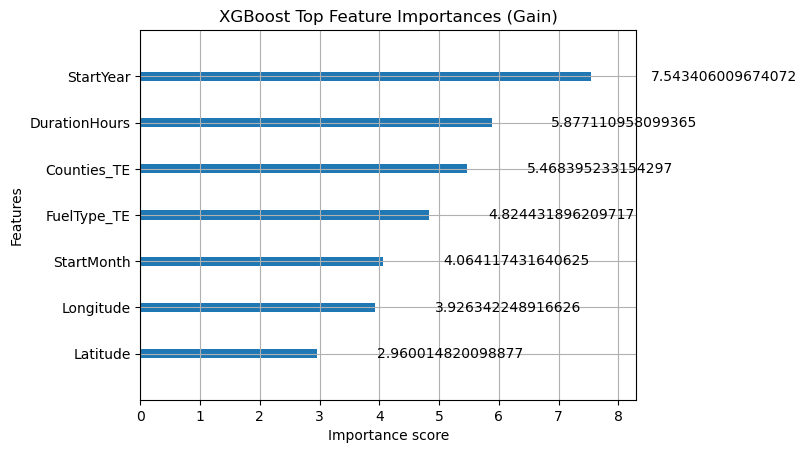

In [111]:
xgb.plot_importance(xgbr_parallel, importance_type='gain', max_num_features=10)
plt.title("XGBoost Top Feature Importances (Gain)")
plt.show()

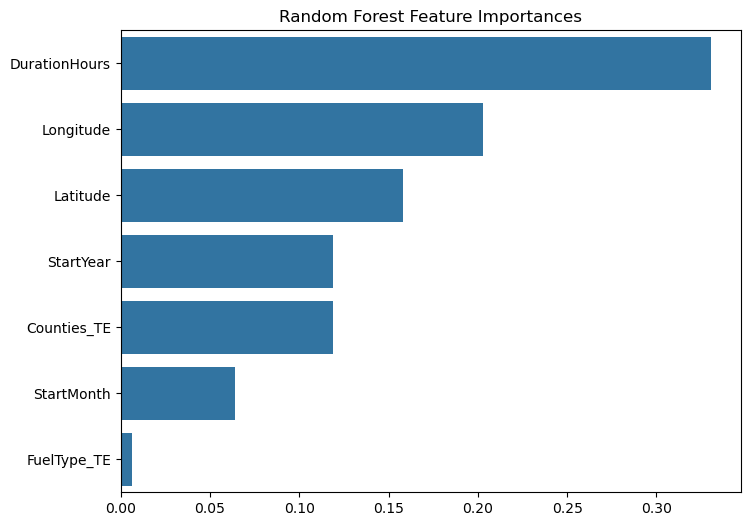

In [112]:
rf_importances = rf_parallel.feature_importances_
indices = np.argsort(rf_importances)[::-1]
plt.figure(figsize=(8, 6))
sns.barplot(x=rf_importances[indices], y=[features[i] for i in indices])
plt.title("Random Forest Feature Importances")
plt.show()

In [113]:
# Collect performance & time data
results = []

# XGBoost Serial
start = time.time()
xgbr_serial.fit(X_train, y_train)
y_pred_xgb_serial = xgbr_serial.predict(X_test)
xgb_serial_time = time.time() - start
rmse, mae, r2 = evaluate_regression_model(y_test, y_pred_xgb_serial, "XGBoost (Serial)")
results.append(["XGBoost Serial", xgb_serial_time, r2, rmse, mae])

# XGBoost Parallel
start = time.time()
xgbr_parallel.fit(X_train, y_train)
y_pred_xgb_parallel = xgbr_parallel.predict(X_test)
xgb_parallel_time = time.time() - start
rmse, mae, r2 = evaluate_regression_model(y_test, y_pred_xgb_parallel, "XGBoost (Parallel)")
results.append(["XGBoost Parallel", xgb_parallel_time, r2, rmse, mae])

# RF Serial
start = time.time()
rf_serial.fit(X_train, y_train)
y_pred_rf_serial = rf_serial.predict(X_test)
rf_serial_time = time.time() - start
rmse, mae, r2 = evaluate_regression_model(y_test, y_pred_rf_serial, "Random Forest (Serial)")
results.append(["Random Forest Serial", rf_serial_time, r2, rmse, mae])

# RF Parallel
start = time.time()
rf_parallel.fit(X_train, y_train)
y_pred_rf_parallel = rf_parallel.predict(X_test)
rf_parallel_time = time.time() - start
rmse, mae, r2 = evaluate_regression_model(y_test, y_pred_rf_parallel, "Random Forest (Parallel)")
results.append(["Random Forest Parallel", rf_parallel_time, r2, rmse, mae])



📊 XGBoost (Serial) Performance
R² Score: 0.3253
RMSE: 1.5845
MAE: 1.2373

📊 XGBoost (Parallel) Performance
R² Score: 0.3253
RMSE: 1.5845
MAE: 1.2373

📊 Random Forest (Serial) Performance
R² Score: 0.3108
RMSE: 1.6013
MAE: 1.2458

📊 Random Forest (Parallel) Performance
R² Score: 0.3108
RMSE: 1.6013
MAE: 1.2458


In [114]:
# Create DataFrame
comparison_df = pd.DataFrame(results, columns=["Model", "TrainTime (s)", "R2 Score", "RMSE", "MAE"])
display(comparison_df)

,Model,TrainTime (s),R2 Score,RMSE,MAE
0,XGBoost Serial,0.042979,0.32529,1.584453,1.237311
1,XGBoost Parallel,0.209297,0.32529,1.584453,1.237311
2,Random Forest Serial,0.512527,0.31083,1.601341,1.245773
3,Random Forest Parallel,0.199966,0.31083,1.601341,1.245773


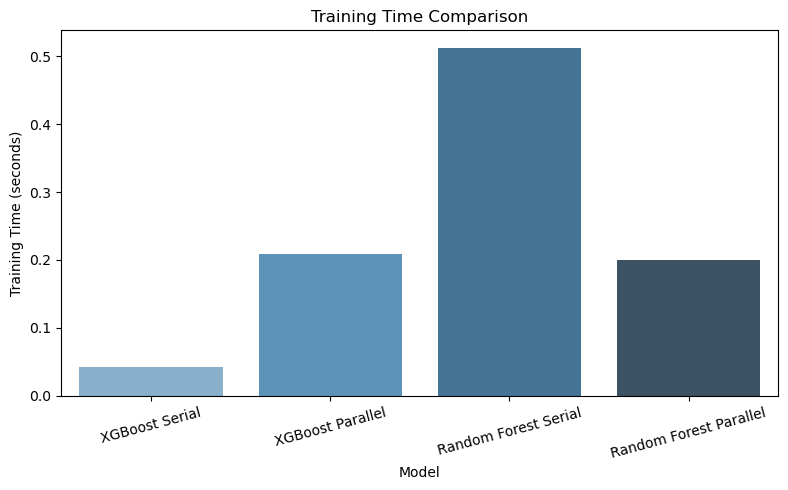

In [115]:
# TRAIN TIME COMPARISON
plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_df, x="Model", y="TrainTime (s)", 
            hue="Model", palette="Blues_d", legend=False)
plt.xticks(rotation=15)
plt.title("Training Time Comparison")  # Removed emoji for now
plt.ylabel("Training Time (seconds)")
plt.tight_layout()
plt.show()


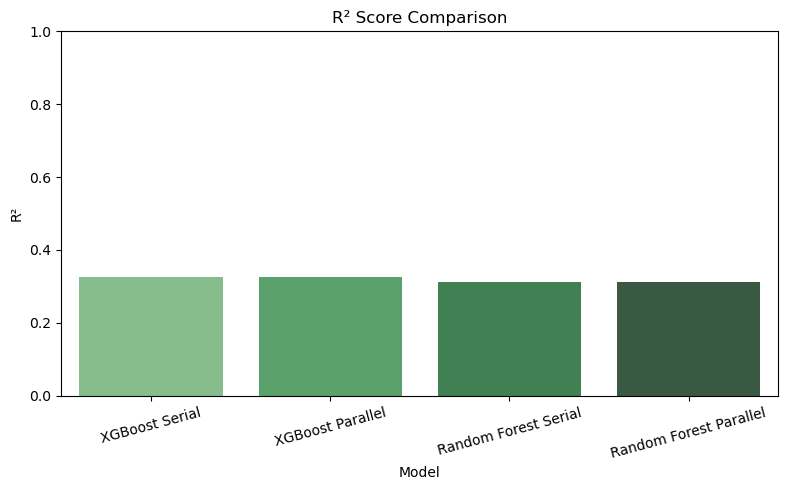

In [116]:
# R² SCORE COMPARISON
plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_df, x="Model", y="R2 Score", 
            hue="Model", palette="Greens_d", legend=False)
plt.xticks(rotation=15)
plt.title("R² Score Comparison")  # Removed emoji to avoid font warning
plt.ylabel("R²")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


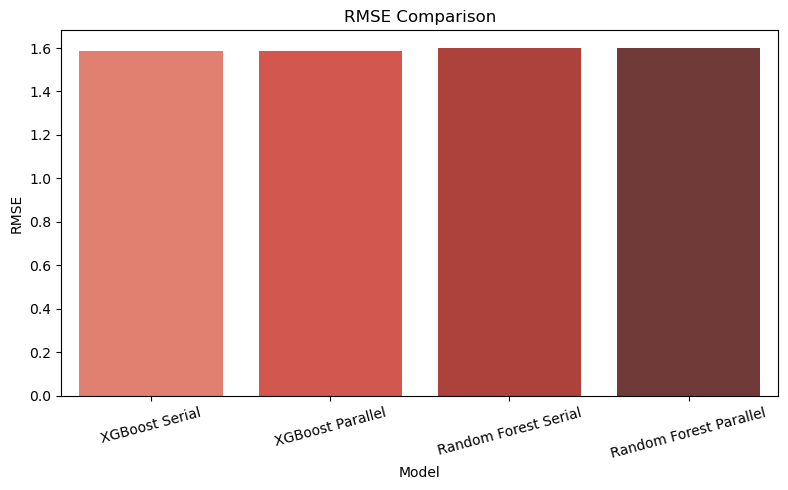

In [117]:
# RMSE COMPARISON
plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_df, x="Model", y="RMSE", 
            hue="Model", palette="Reds_d", legend=False)
plt.xticks(rotation=15)
plt.title("RMSE Comparison")  # Removed emoji to avoid font warning
plt.tight_layout()
plt.show()

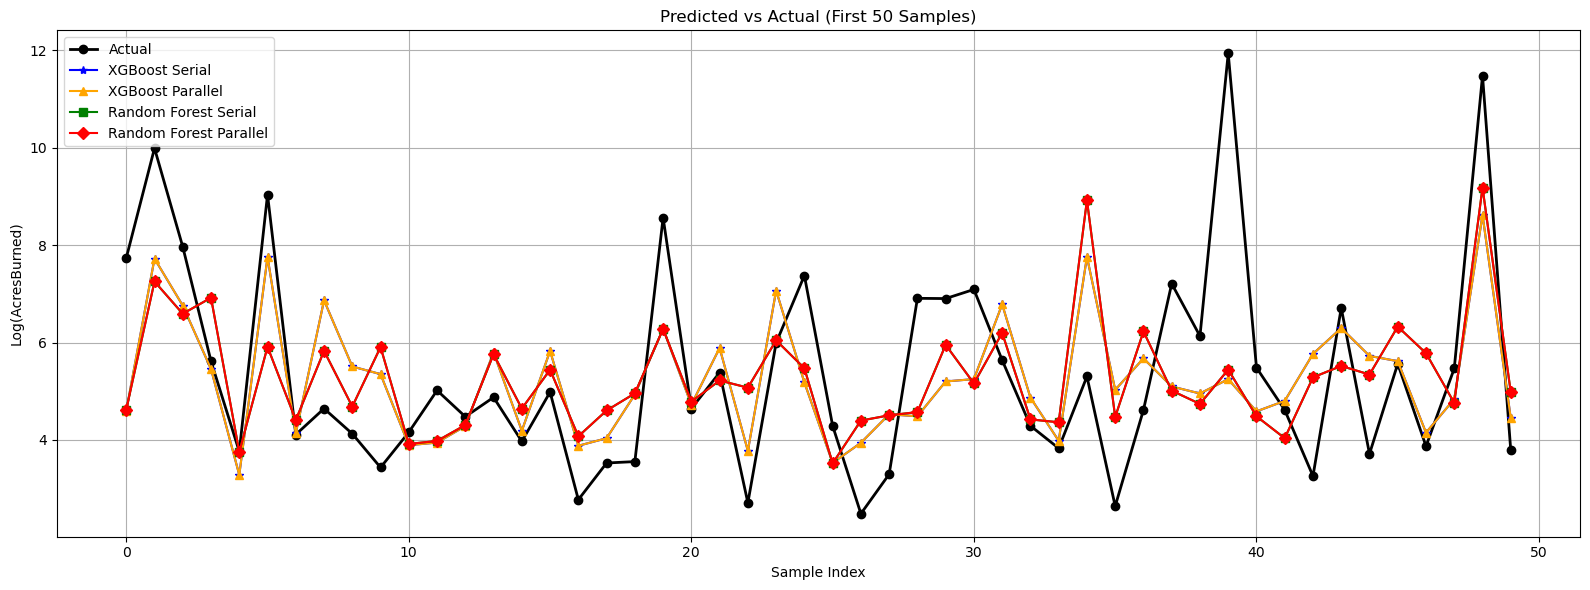

In [118]:
import matplotlib.pyplot as plt

# Select first N samples for visual clarity
N = 50
sample_indices = range(N)

# Collect predictions
y_actual = y_test[:N].values
y_pred_xgb_serial = xgbr_serial.predict(X_test)[:N]
y_pred_xgb_parallel = xgbr_parallel.predict(X_test)[:N]
y_pred_rf_serial = rf_serial.predict(X_test)[:N]
y_pred_rf_parallel = rf_parallel.predict(X_test)[:N]

# Plot
plt.figure(figsize=(16, 6))

# Actual
plt.plot(sample_indices, y_actual, 'ko-', label="Actual", linewidth=2)

# XGBoost Serial
plt.plot(sample_indices, y_pred_xgb_serial, 'b*-', label="XGBoost Serial")

# XGBoost Parallel
plt.plot(sample_indices, y_pred_xgb_parallel, '^-', color='orange', label="XGBoost Parallel")

# RF Serial
plt.plot(sample_indices, y_pred_rf_serial, 'gs-', label="Random Forest Serial")

# RF Parallel
plt.plot(sample_indices, y_pred_rf_parallel, 'rD-', label="Random Forest Parallel")

# Formatting
plt.title("Predicted vs Actual (First 50 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Log(AcresBurned)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
